In [2]:
import json

# Load the JSON file
with open("./../sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [3]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

In [4]:
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [6]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [7]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
num_epochs = 20

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

ERROR! Session/line number was not unique in database. History logging moved to new session 270
Train on 20000 samples, validate on 6709 samples
Epoch 1/20
20000/20000 - 5s - loss: 0.3125 - accuracy: 0.8733 - val_loss: 0.3409 - val_accuracy: 0.8547
Epoch 2/20
20000/20000 - 4s - loss: 0.2351 - accuracy: 0.9085 - val_loss: 0.3434 - val_accuracy: 0.8547
Epoch 3/20
20000/20000 - 4s - loss: 0.1898 - accuracy: 0.9269 - val_loss: 0.3586 - val_accuracy: 0.8556
Epoch 4/20
20000/20000 - 5s - loss: 0.1574 - accuracy: 0.9421 - val_loss: 0.3837 - val_accuracy: 0.8547
Epoch 5/20
20000/20000 - 5s - loss: 0.1332 - accuracy: 0.9524 - val_loss: 0.4167 - val_accuracy: 0.8474
Epoch 6/20
20000/20000 - 5s - loss: 0.1136 - accuracy: 0.9612 - val_loss: 0.4528 - val_accuracy: 0.8454
Epoch 7/20
20000/20000 - 4s - loss: 0.0988 - accuracy: 0.9670 - val_loss: 0.5021 - val_accuracy: 0.8390
Epoch 8/20
20000/20000 - 5s - loss: 0.0850 - accuracy: 0.9722 - val_loss: 0.5592 - val_accuracy: 0.8304
Epoch 9/20
20000/20000 

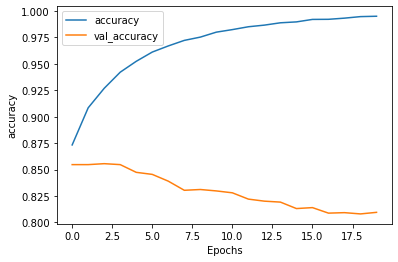

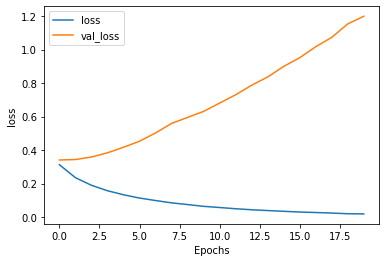

In [10]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


In [12]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [26]:
tokenizer.word_index.keys()

dict_keys(['<OOV>', 'to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with', 'is', 'new', 'trump', 'man', 'from', 'at', 'about', 'you', 'by', 'this', 'after', 'be', 'up', 'out', 'that', 'how', 'as', 'it', 'not', 'are', 'your', 'what', 'his', 'all', 'he', 'will', 'who', 'just', 'has', 'more', 'one', 'year', 'into', 'report', 'have', 'why', 'over', 'area', 'u', 'donald', 'says', 'day', 'can', 's', 'first', 'woman', 'time', 'like', 'get', 'old', 'no', 'her', "trump's", 'off', 'now', 'an', 'obama', 'life', 'people', 'women', 'house', "'", 'was', 'still', 'white', 'back', 'make', 'than', 'clinton', 'down', 'when', 'my', '5', 'could', 'world', 'americans', 'if', 'i', 'we', 'way', 'their', 'most', 'study', 'they', 'before', 'family', 'do', 'gop', 'best', 'black', "it's", 'bill', 'school', 'but', 'only', 'police', 'him', 'so', 'years', 'president', 'know', '3', 'being', 'watch', 'should', 'would', 'last', 'really', '10', 'video', 'show', "can't", 'going', 'death', 'hillary', 'during', 'finds'

In [28]:
tokenizer.index_word.values()

dict_values(['<OOV>', 'to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with', 'is', 'new', 'trump', 'man', 'from', 'at', 'about', 'you', 'by', 'this', 'after', 'be', 'up', 'out', 'that', 'how', 'as', 'it', 'not', 'are', 'your', 'what', 'his', 'all', 'he', 'will', 'who', 'just', 'has', 'more', 'one', 'year', 'into', 'report', 'have', 'why', 'over', 'area', 'u', 'donald', 'says', 'day', 'can', 's', 'first', 'woman', 'time', 'like', 'get', 'old', 'no', 'her', "trump's", 'off', 'now', 'an', 'obama', 'life', 'people', 'women', 'house', "'", 'was', 'still', 'white', 'back', 'make', 'than', 'clinton', 'down', 'when', 'my', '5', 'could', 'world', 'americans', 'if', 'i', 'we', 'way', 'their', 'most', 'study', 'they', 'before', 'family', 'do', 'gop', 'best', 'black', "it's", 'bill', 'school', 'but', 'only', 'police', 'him', 'so', 'years', 'president', 'know', '3', 'being', 'watch', 'should', 'would', 'last', 'really', '10', 'video', 'show', "can't", 'going', 'death', 'hillary', 'during', 'find

ERROR! Session/line number was not unique in database. History logging moved to new session 277


In [13]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')